# Lesson 6: Metaprompting with o1

Optimizing to production is one of the biggest painpoints we've seen developers experience with working with LLMs - with so much guidance for prompt engineering, RAG and fine-tuning out there, figuring out which optimization you need to hill-climb on your evals can be a difficult problem to frame and solve.

Luckily, it appears to be one of the use cases that `o1` is capable at, this modification uses gpt-5. In this session we'll focus on how to use `o3-mini` to work with a set of evals to optimize our prompt for the task and improve score on our evals.


<div style="background-color:#fff6ff; padding:13px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px">
<p> 💻 &nbsp; <b>Access <code>requirements.txt</code> and <code>helper.py</code> files:</b> 1) click on the <em>"File"</em> option on the top menu of the notebook and then 2) click on <em>"Open"</em>.

<p> ⬇ &nbsp; <b>Download Notebooks:</b> 1) click on the <em>"File"</em> option on the top menu of the notebook and then 2) click on <em>"Download as"</em> and select <em>"Notebook (.ipynb)"</em>.</p>

<p> 📒 &nbsp; For more help, please see the <em>"Appendix – Tips, Help, and Download"</em> Lesson.</p>

</div>

<p style="background-color:#f7fff8; padding:15px; border-width:3px; border-color:#e0f0e0; border-style:solid; border-radius:6px"> 🚨
&nbsp; <b>Different Run Results:</b> The output generated by AI models can vary with each execution due to their dynamic, probabilistic nature. Don't be surprised if your results differ from those shown in the video.</p>

In [54]:
# Warning control
import warnings
warnings.filterwarnings('ignore')

# Import OpenAI key
from helper import get_azure_openai_api_key
from helper import get_openai_api_key

openai_api_key = get_openai_api_key()
azure_openai_api_key = get_azure_openai_api_key()

In [55]:
from openai import AzureOpenAI
from openai import OpenAI
from IPython.display import display, Markdown
import pandas as pd
from concurrent.futures import ThreadPoolExecutor
from functionDefinitions import TOOLS
import csv
import json
import os
import matplotlib.pyplot as plt

GPT_MODEL = 'agent-chatbot-gpt-4o-mini'
SUPER_MODEL = 'agent-chatbot-gpt-5'

client = OpenAI(api_key=openai_api_key)

# Azure example: https://github.com/Azure/azure-sdk-for-python/blob/main/sdk/openai/azure-openai/samples/chat_completions_aoai_quickstart.py
azure_client = AzureOpenAI(
        azure_endpoint=os.environ["AZURE_OPENAI_QA_ENDPOINT"],
        api_key=azure_openai_api_key,
        api_version="2025-01-01-preview"
    )

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)


In [56]:
from redlines import Redlines
from IPython.display import display, Markdown

def compare_strings(string1, string2):
    # Create a Redlines object to compare the strings
    diff = Redlines(string1, string2)
    
    # Display the differences using Markdown
    display(Markdown(diff.output_markdown))

# Example usage
string_a = "This is the original text for comparison purposes."
string_b = "This is the modified text to compare for differences."

compare_strings(string_a, string_b)

This is the <span style='color:red;font-weight:700;text-decoration:line-through;'>original </span><span style='color:green;font-weight:700;'>modified </span>text <span style='color:green;font-weight:700;'>to compare </span>for <span style='color:red;font-weight:700;text-decoration:line-through;'>comparison purposes.</span><span style='color:green;font-weight:700;'>differences.</span>

## Step 1: Generate 4o routine (prompt)

We'll take the Flight Cancellation Policy that we have created and convert it to an LLM-based routine with the following prompt.

This process is also a good use of O1, using a purely text document to create instructions and tools for an LLM to make use of. To dive deeper on this topic check out [this cookbook](https://cookbook.openai.com/examples/o1/using_reasoning_for_routine_generation).

In [57]:
with open('originalPolicy/flightCancellationsPolicy.md', 'r') as file:
    flight_cancellation_policy = file.read()
    print(flight_cancellation_policy)

# **Internal Flight Cancellations and Changes Policy**

**Purpose**: This document serves as a detailed guide for internal support agents to handle flight cancellations and changes. The focus is on providing clear instructions, ensuring efficiency, consistency, and customer satisfaction during calls.

**Note**: Always maintain a calm, empathetic tone while assisting customers, especially during stressful situations involving cancellations or major changes.

## **Table of Contents**

1. General Guidelines for Handling Customer Requests  
2. Cancellations: Types and Policies  
3. Changes: Types and Policies  
4. Rebooking Guidelines  
5. Compensation and Refund Rules  
6. Special Cases  
7. FAQs for Common Scenarios

### **1\. General Guidelines for Handling Customer Requests**

* **Confirm Identity**: Verify the customer's identity by asking for their booking reference and any additional required details (e.g., name and flight number).  
* **Listen and Understand**: Clarify if the custo

In [58]:
# TODO : remove when we can improve the original routine
CONVERSION_PROMPT = f"""
You are a helpful assistant tasked with taking an external facing help center article and converting it into a internal-facing programmatically executable routine optimized for an LLM. 
The LLM using this routine will be tasked with reading the policy, answering incoming questions from customers, and helping drive the case toward resolution.

Please follow these instructions:
1. **Review the customer service policy carefully** to ensure every step is accounted for. It is crucial not to skip any steps or policies.
2. **Organize the instructions into a logical, step-by-step order**, using the specified format. 
3. **Use the following format**:
   - **Main actions are numbered** (e.g., 1, 2, 3).
   - **Sub-actions are lettered** under their relevant main actions (e.g., 1a, 1b).
      **Sub-actions should start on new lines**
   - **Specify conditions using clear 'if...then...else' statements** (e.g., 'If the product was purchased within 30 days, then...').
   - **For instructions that require more information from the customer**, provide polite and professional prompts to ask for additional information.
   - **For actions that require data from external systems**, write a step to call a function using backticks for the function name (e.g., call the `check_delivery_date` function).
      - **If a step requires the customer service agent to take an action** (e.g., process a refund), generate a function call for this action (e.g., call the `process_refund` function).
      - **Only use the available set of functions that are defined below.
   - **If there is an action an assistant can perform on behalf of the user**, include a function call for this action (e.g., call the `change_email_address` function), and ensure the function is defined with its purpose and required parameters.
      - **Only use the available set of functions that are defined below.
   - **The step prior to case resolution should always be to ask if there is anything more you can assist with**.
   - **End with a final action for case resolution**: calling the `case_resolution` function should always be the final step.
4. **Ensure compliance** by making sure all steps adhere to company policies, privacy regulations, and legal requirements.
5. **Handle exceptions or escalations** by specifying steps for scenarios that fall outside the standard policy.
6. **Ensure coverage** by checking that all of the conditions covered in the policy are also covered in the routines

**Important**: Always wrap the functions you return in backticks i.e. `check_ticket_type`. Do not include the arguments to the functions.

Here are the currently available set of functions in JSON format: 
TOOLS: {TOOLS}

Please convert the following customer service policy into the formatted routine, ensuring it is easy to follow and execute programmatically. Ensure that you **only** use the functions provided and do **not** create net new functions."""

In [59]:
def generate_routine(policy):
    try:
        messages = [
            {
                "role": "user",
                "content": f"""
                    {CONVERSION_PROMPT}

                    POLICY:
                    {policy}
                """
            }
        ]
        print("Generating routine...")
        response = azure_client.chat.completions.create(
            model='gpt-o3-mini-model-no-pii',
            messages=messages
        )
        

        return response.choices[0].message.content 
    except Exception as e:
        print(f"An error occurred: {e}")

In [60]:
#flight_cancellation_routine = generate_routine(flight_cancellation_policy)
with open('original_routine.md', 'r') as file:
    vehicle_bot_routine= file.read()
    print(vehicle_bot_routine)

## 1. Role Identification
**Act as:** A Volvo Cars customer care agent that helps customer troubleshoot vehicle related issue. Your task is to provide answers to the user's inquiries based solely on the information retrieved from specified sources.
---
## 2. Use Tools and Answer Groundedness
- Your final answer must strictly rely on the information obtained from the retrieved sources.
- Use the tools only when the user provided a complete problem statement for the vehicle issue
- If the answer isn't present in the Tool result, ask for clarification using predefined follow up questions.
- A Vehicle Identification Number (VIN), consists of exactly 17 characters (digits and letters only) and conforms with regex [A-HJ-NPR-Z0-9]{17}."
- Example car models are EX30, EX90, C40, XC40, XC60, XC90, V60, V90, S60, S90, detect car model from the user inputs based on word similarity to these examples.
- The knowledgeSearch tool is the default tool to be used, do not rephrase and call again if first

In [61]:
display(Markdown(vehicle_bot_routine))

## 1. Role Identification
**Act as:** A Volvo Cars customer care agent that helps customer troubleshoot vehicle related issue. Your task is to provide answers to the user's inquiries based solely on the information retrieved from specified sources.
---
## 2. Use Tools and Answer Groundedness
- Your final answer must strictly rely on the information obtained from the retrieved sources.
- Use the tools only when the user provided a complete problem statement for the vehicle issue
- If the answer isn't present in the Tool result, ask for clarification using predefined follow up questions.
- A Vehicle Identification Number (VIN), consists of exactly 17 characters (digits and letters only) and conforms with regex [A-HJ-NPR-Z0-9]{17}."
- Example car models are EX30, EX90, C40, XC40, XC60, XC90, V60, V90, S60, S90, detect car model from the user inputs based on word similarity to these examples.
- The knowledgeSearch tool is the default tool to be used, do not rephrase and call again if first tool call is not finding relevant information.
- Use all user questions to understand the context and provide accurate answers.
- Use a tool only once per user question
---
## 3. Explicit Source Requirement
- Cite only the results obtained from the tools that were used to formulate your answer.
- Ensure that all cited sources are directly relevant to the information provided in your answer.
- Avoid including irrelevant sources or information that does not directly pertain to the user's question.
---
## 4. Response Guidance
- User inputs must describe the problem with the vehicle and a registration number or car model
- Ensure that all responses are strictly based on the information retrieved from the designated sources, without incorporating any external knowledge, assumptions, or interpretations.
- If errors occur from retrieved sources, clearly state the error details and explain the reason for the failure in your response.
---
## 5. Output Format Requirements
- Reply in JSON format, no formatting around it.
- Use the format ONLY if the search tool returns a result with sources: {"type":".SearchAgentResult","sources":[{"title":"...","url":"...","carDisplayName":"..."}],"response":"..."}
---
## 6. When the user messages do not provide a complete problem statement for the issue or an error occur, pick the most appropriate follow up question from this list:
["Could you please provide the car model or registration number?","Can you describe what the problem is?","I encountered an error, can you rephrase your issue and be more specific?"] to return to the user to collect more context. Put the question inside this template: {"type":".AgentResultNeedsClarification","question":"question to the user"}.
- If you cannot infer car model or registration number use the question from above predefined questions that asks for car model or registration number.
- Do not translate the predefined question, use it in the same language as it is defined above, no rewording too.

### Data quality check

We'll check that `o3-mini` has followed our instructions and used only the functions we provided.

If it added additional ones, we'll need to write functions for them before proceeding.

In [62]:
import re
from collections import Counter

def compare_lists(a, b):
    # Create Counters for both lists
    counter_a = Counter(a)
    counter_b = Counter(b)
    
    # Find elements that are only in A or have a higher count in A
    diff_a = counter_a - counter_b
    # Find elements that are only in B or have a higher count in B
    diff_b = counter_b - counter_a
    
    # Report differences
    print("Items in A that are not in B (or more of in A):")
    for item, count in diff_a.items():
        print(f"{item}: {count}")

    print("\nItems in B that are not in A (or more of in B):")
    for item, count in diff_b.items():
        print(f"{item}: {count}")

def extract_function_names(text):
    # Use regex to match text between backticks and extract function names
    pattern = r'`(.*?)`'
    matches = re.findall(pattern, text)
    return matches

# Extract a unique list of the functions in the generated routine
function_names_from_o1 = set(extract_function_names(vehicle_bot_routine))

# Extract the list of TOOLs we provided the model
function_names_defined = [tool["function"]["name"] for tool in TOOLS if tool["type"] == "function"]

# Print the differences
## Items that are in A and not in B need functions written for them
## Items that are in B and not in A are fine, they are just unused in the routine the model has written
compare_lists(function_names_from_o1, function_names_defined)

Items in A that are not in B (or more of in A):

Items in B that are not in A (or more of in B):
getVehicleByVIN: 1
getVehiclesByRegistrationNumber: 1
EnglishKnowledgeSearch: 1


## Step 2: Evaluation

Now that we have a routine generated with o1, we can run it against our evaluation suite and measure its accuracy.

We'll start by creating an agent that is equipped with the policy and a list of tools. It will be given messages from an existing conversation and will be tasked with determining the next best action to take

In [63]:
def agent_response(transcript, policy, model):
    try:
        messages = [
            {
                "role": "system",
                "content": f"""
You are a customer service agent that is responsible for handling airline related issues. Below is the exact policy that you must follow to address the customer's issue.

POLICY:
{policy}
                """
            }
        ]

        messages.extend(transcript)
        response = azure_client.chat.completions.create(
            model=model,
            messages=messages,
            tools=TOOLS,
            parallel_tool_calls=False,
        temperature=0)
        
        return response.choices[0].message 
    except Exception as e:
        print(f"An error occurred: {e}")
        print(messages)

We will process each row in parallel to reduce runtime and compare the function call + inputs that the model selects against our expected function + parameters.

In [64]:
import math 

def safe_str(value):
    return "" if (isinstance(value, float) and math.isnan(value)) else str(value)

def compare_json_content(actual, expected_str):
    """Compare two JSON objects for content equality, not string equality."""
    # Handle None/NaN cases
    if pd.isna(expected_str) or not expected_str:
        return actual is None or actual == ""
    
    try:
        # Parse expected string to JSON if it's a string
        expected_obj = json.loads(expected_str) if isinstance(expected_str, str) else expected_str
        
        # Parse actual to JSON if it's a string
        actual_obj = json.loads(actual) if isinstance(actual, str) and actual else actual
        
        # Compare the parsed objects
        return actual_obj == expected_obj
    except (json.JSONDecodeError, TypeError):
        # Fall back to string comparison if JSON parsing fails
        return safe_str(actual) == safe_str(expected_str)

def process_row(row_number,test_row,policy,model,iteration=0, verbose=False):
    # Extract variables from test_row
    context = test_row['context']
    request = test_row['request']
    expected_function = test_row['expected_function']
    expected_response_str = test_row['expected_response']
    
    # Handle potential JSON parsing errors
    try:
        expected_response = json.loads(expected_response_str) if pd.notna(expected_response_str) and expected_response_str else None
    except json.JSONDecodeError as e:
        print(f"Warning: JSON decode error in row {row_number}: {e}")
        print(f"Problematic value: {expected_response_str[:200]}...")
        expected_response = None

    # Initialize transcript
    transcript = [{"role": "user", "content": request}]
    if verbose:
        print(f'Starting request: {request}')
    
    # Initialize variables
    is_function_correct = False
    is_response_correct = False

    response = agent_response(transcript, policy, GPT_MODEL)

    if response:
        actual_response = response.content
        tool_calls = response.tool_calls
        actual_response = response.content
        tool_calls = response.tool_calls
        if not tool_calls:
            actual_function = "none"
        else:
            tool_call = tool_calls[0]
            actual_function = tool_call.function.name
            arguments = json.loads(tool_call.function.arguments)
                
            # Simulate tool response
            tool_response = f'Simulated response for {actual_function} with arguments {arguments}'
                
            # Append the tool response to transcript
            transcript.append({"role": "tool", "content": tool_response, "tool_call_id": tool_call.id})

    else:
        actual_response = None
        tool_calls = None

    is_function_correct = (actual_function == expected_function)
    is_response_correct = compare_json_content(actual_response, expected_response_str)
    
    # Return the results
    return {
        'request': request,
        'context': context,
        'expected_function': expected_function,
        'actual_function': actual_function,
        'expected_response': expected_response,
        'actual_response': actual_response,
        'is_function_correct': is_function_correct,
        'is_response_correct': is_response_correct,
        'transcript': transcript
    }

# added post-filming to address transcript size
def filter_messages(message_list):
    messages = []
    for item in message_list:
        # Convert the item to a string and check if 'ChatCompletionMessage' is in it.
        if 'ChatCompletionMessage' in str(item):
            #print(item)
            message = {"role": "assistant",
                       "tool_call": {
                           "name": item.tool_calls[0].function.name,
                           "arguments": item.tool_calls[0].function.arguments
                       }
                      }
            messages.append(message)
        else:
            messages.append(item)
    return messages


def evaluate_function_calls(df, policy, model, i=0, verbose=False):
    records = []

    # Use ThreadPoolExecutor to process rows in parallel
    with ThreadPoolExecutor() as executor:
        futures = {executor.submit(process_row, row_number, row, policy, model, i, verbose): row_number for row_number, row in df.iterrows()}
        for future in futures:
            record = future.result()
            records.append(record)


    df = pd.DataFrame(records)
    df['cleaned_transcript'] = df['transcript'].apply(filter_messages)
    # Calculate is_correct as both function and response being correct
    df['is_correct'] = df['is_function_correct'] & df['is_response_correct']
    total_accuracy = df['is_correct'].mean()
    return df, total_accuracy


Let's take a look at the results

In [65]:
eval_df = pd.read_csv('evals/policyEvals.csv')
eval_df.head()

,ID,context,request,expected_function,expected_response
0,0,I need help with my car,I need help with my car,none,"{""question"":""Can you describe what the problem is?"",""type"":"".AgentResultNeedsClarification""}"
1,1,I need car dimensions,I need car dimensions,none,"{""type"":"".AgentResultNeedsClarification"",""question"":""Could you please provide the car model or registration number?""}"


In [66]:
from termcolor import colored

def display_row(index):
    eval_row = eval_df.iloc[index]
    df_row = df.iloc[index][["actual_function", "is_correct", "cleaned_transcript"]]
    transcript_list = df_row["cleaned_transcript"]

    print("Eval DataFrame Row:")
    print(eval_row)
    print("\nDataFrame Columns:")
    print("actual_function:", df_row["actual_function"])
    print("is_correct:", df_row["is_correct"])
    print("transcript:")
    for entry in transcript_list:
        role = entry["role"] if isinstance(entry, dict) else getattr(entry, "role", None)
        color = "blue" if role == "user" else "red"
        print(colored(str(entry), color))


In [67]:
df, accuracy = evaluate_function_calls(eval_df, vehicle_bot_routine, GPT_MODEL)

# Display the accuracy as a mini header
display(Markdown(f"### Accuracy: {accuracy:.2%}"))

display(df)

### Accuracy: 50.00%

,request,context,expected_function,actual_function,expected_response,actual_response,is_function_correct,is_response_correct,transcript,cleaned_transcript,is_correct
0,I need help with my car,I need help with my car,none,none,"{'question': 'Can you describe what the problem is?', 'type': '.AgentResultNeedsClarification'}","{""type"":"".AgentResultNeedsClarification"",""question"":""Could you please provide the car model or registration number?""}",True,False,"[{'role': 'user', 'content': 'I need help with my car'}]","[{'role': 'user', 'content': 'I need help with my car'}]",False
1,I need car dimensions,I need car dimensions,none,none,"{'type': '.AgentResultNeedsClarification', 'question': 'Could you please provide the car model or registration number?'}","{""type"":"".AgentResultNeedsClarification"",""question"":""Could you please provide the car model or registration number?""}",True,True,"[{'role': 'user', 'content': 'I need car dimensions'}]","[{'role': 'user', 'content': 'I need car dimensions'}]",True


In [68]:
display_row(1)

Eval DataFrame Row:
ID                                                                                                                                       1
context                                                                                                              I need car dimensions
request                                                                                                              I need car dimensions
expected_function                                                                                                                     none
expected_response    {"type":".AgentResultNeedsClarification","question":"Could you please provide the car model or registration number?"}
Name: 1, dtype: object

DataFrame Columns:
actual_function: none
is_correct: True
transcript:
{'role': 'user', 'content': 'I need car dimensions'}


## Step 3: Improve 4o routine

Let's now leverage o1 again to add in a metaprompting loop to see if we can improve the quality of our evals.

We'll take the following multi-step approach:
- We'll pass in the current routine + eval results to o1 and ask it analyze the results and update the routine accordingly
- Since o1 does not currently support structured outputs, we'll chain with output with a 4o to enforce a schema we can parse
- Finally, we take the new routine and run it back through our eval to generate new results

We'll run this loop a fixed number of times and see what improvements we can make

In [69]:
def get_openai_response(messages, model, response_format=None):
    try:
        if response_format:
            response = azure_client.chat.completions.create(
                model=model,
                messages=messages,
                response_format={"type": "json_schema", "json_schema": response_format}
            )
        else:
            response = azure_client.chat.completions.create(
                model=model,
                messages=messages
            )
        return response.choices[0].message.content
    except Exception as e:
        print(f"An error occurred: {e}")


OUTPUT_SCHEMA = {
                    "name": "policy_output",
                    "schema": {
                    "type": "object",
                    "properties": {
                        "final_answer": { "type": "string" }
                    },
                    "required": ["final_answer"],
                    "additionalProperties": False
                    },
                    "strict": True
                }

In [70]:
def get_azure_openai_response(messages, model, response_format=None):
    try:
        i = 0
    except Exception as e:
        print(f"An error occurred: {e}")

In [71]:
start_o1_message = [
    {
        "role": "user",
        "content": f"""# Instructions
You are an agent that is responsible for improving the quality of instructions that are provided to a customer service LLM agent. 
Your task is to improve the instructions that are provided to the LLM agent in order to increase accuracy on a test set while adhering to the initial policy. 

## Criteria
- Analyze the existing instructions and the results of the eval. Understand which behaviors lead to failures.
- For example, if the LLM agent is not asking for the booking reference when it is needed, you should add a step to ask for the booking reference.
- Improve the instructions to address the gaps in the eval results.
- Ensure changes made are compliant with the original policy.
- Only use the tools provided.
- Use the functions provided to the best of your ability to ensure the LLM agent can handle the customer service requests effectively. Including gathering data where necessary.
- Try changing the format if this formatting doesn't work well - consider basic XML (e.g. <step> <substep> <if> <case>) or markdown as alternatives.

You will be provided with 4 items:
1) The ground-truth policy for the customer service agent containing detailed instructions on how to handle inquires from Volvo car owners.
2) Full list of available functions.
3) A routine instruction set.
4) A results that shows the LLMs performance on a test set using this routine instruction set. This dataset contains columns showing:
    - request: This is the initial user request. 
    - expected_function: This is the function we expect the LLM to call at the end of the conversation. 
    - expected_input: This is the input we expect the LLM to provide to the function at the end of the conversation.
    - actual_function: This is the final function the LLM called using the current instructions.
    - actual_input: These are the function parameters the LLM provided based on the current instructions.
    - transcript: This is the conversation transcript between the user and the LLM agent. 
    - is_correct: True/False value depending on if the model responded correctly

You may be provided with a history of edits and evaluations. You can use this information to understand what has been tried before and what has worked or not worked.

# Data

## 1. Original policy
{vehicle_bot_routine}

## 2. Functions
{TOOLS}

# Conclusion

Return the improved policy exactly as written within the defined JSON. Remove all parts from the LLM's answer that are not part of the policy, and do not create additional keys.
"""
     }
]

In [72]:
import tiktoken 

encoding = tiktoken.get_encoding("o200k_base")

def num_tokens_from_messages(messages):
    entire_input = ""
    for message in messages:
        entire_input += message["content"] + " "
    tokens = encoding.encode(entire_input)
    return len(tokens)

When improving the routine, consider these approaches:
- Adding synthetic examples to show the model how to choose between two commonly mistaken functions
- Given it general guidance on what attributes to look out for which it commonly mislabels
- Being more specific with your guidance on how to follow the routine.

<p style="background-color:#f7fff8; padding:15px; border-width:3px; border-color:#e0f0e0; border-style:solid; border-radius:6px"> 🚨
&nbsp; <b>High Token Warning!:</b> Running the following cell consumes many tokens. Running multiple times may result in a message regarding exceeding a monthy quota.</p>

In [73]:
# start with data from first run
routines = [vehicle_bot_routine]
results = [df]
accuracies = [round(accuracy * 100, 2)]
o1_messages = start_o1_message.copy()

MAX_TOKENS = 120000

for i in range(6):
    display(Markdown(f"## Iteration {i+1}"))
    
    # Build a candidate message with the most recent eval (full table)
    prev_results = results[-1]
    pf = prev_results.drop(columns=['transcript'])

    new_eval_content = (
        f"## 3. Routine instructions:\n"
        f"{routines[-1]}\n"
        f"## 4. Results table:\n"
        f"{pf.to_json(orient='records')}\n"
    )
    
    # Check token count before adding the newest eval
    candidate_messages = o1_messages + [{"role": "user", "content": new_eval_content}]
    if num_tokens_from_messages(candidate_messages) <= MAX_TOKENS:
        o1_messages.append({"role":"user", "content": new_eval_content})
    else:
        # If we can't even fit the newest eval, consider truncation or error handling
        # For simplicity, we skip truncation logic here
        print("excluding eval content {num_tokens_from_messages(candidate_messages)}")
        pass

    print(f"num tokens {num_tokens_from_messages(o1_messages)}")
    print(f"len messages {len(o1_messages)}")


    # Get the updated routine from the metaprompting assistant
    temp_routine_json = get_openai_response(o1_messages
                                            , SUPER_MODEL
                                            ,response_format=OUTPUT_SCHEMA)
    #temp_routine_str = temp_routine_json.strip("json```").strip("```")
    new_routine = json.loads(temp_routine_json)["final_answer"]
    routines.append(new_routine)

    eval_df = pd.read_csv('evals/policyEvals.csv')

    # Evaluate the function calls with the current policy on the gpt-4o model
    eval_df, accuracy = evaluate_function_calls(
        eval_df,
        new_routine,
        GPT_MODEL,
        i
    )
    accuracies.append(round(accuracy * 100, 2))
    results.append(eval_df)
    display(Markdown(f"### Accuracy: {accuracy:.2%}"))

    #list the IDs of the failed rows
    failed_ids = eval_df[eval_df['is_correct'] == False].index.tolist()
    display(eval_df.loc[failed_ids])
    eval_df.to_csv(f'evals/results_run_{i+1}.csv', index=False)

    # Instantiate fresh o1 message
    o1_messages = start_o1_message.copy()

    # Attempt to include older examples (omitting 'transcript') within token limit
    older_results = results[:-1][::-1]  # all except the newest, reversed for most recent first
    for old_eval_df in older_results:
        if 'transcript' in old_eval_df.columns:
            truncated_df = old_eval_df.drop(columns=['transcript','cleaned_transcript'])
        else:
            truncated_df = old_eval_df

        old_content = "## Older eval (no transcript):\n" + truncated_df.to_json(orient='records')
        candidate_messages = o1_messages + [{"role": "user", "content": old_content}]
        if num_tokens_from_messages(candidate_messages) <= MAX_TOKENS:
            o1_messages.append({"role": "user", "content": old_content})
        else:
            # If we exceed token limits, stop adding older examples
            break


## Iteration 1

num tokens 2622
len messages 2


### Accuracy: 100.00%

,request,context,expected_function,actual_function,expected_response,actual_response,is_function_correct,is_response_correct,transcript,cleaned_transcript,is_correct


## Iteration 2

num tokens 3155
len messages 3


### Accuracy: 100.00%

,request,context,expected_function,actual_function,expected_response,actual_response,is_function_correct,is_response_correct,transcript,cleaned_transcript,is_correct


## Iteration 3

num tokens 3879
len messages 4


### Accuracy: 100.00%

,request,context,expected_function,actual_function,expected_response,actual_response,is_function_correct,is_response_correct,transcript,cleaned_transcript,is_correct


## Iteration 4

num tokens 4355
len messages 5


### Accuracy: 100.00%

,request,context,expected_function,actual_function,expected_response,actual_response,is_function_correct,is_response_correct,transcript,cleaned_transcript,is_correct


## Iteration 5

num tokens 4780
len messages 6


### Accuracy: 100.00%

,request,context,expected_function,actual_function,expected_response,actual_response,is_function_correct,is_response_correct,transcript,cleaned_transcript,is_correct


## Iteration 6

num tokens 5214
len messages 7


### Accuracy: 100.00%

,request,context,expected_function,actual_function,expected_response,actual_response,is_function_correct,is_response_correct,transcript,cleaned_transcript,is_correct


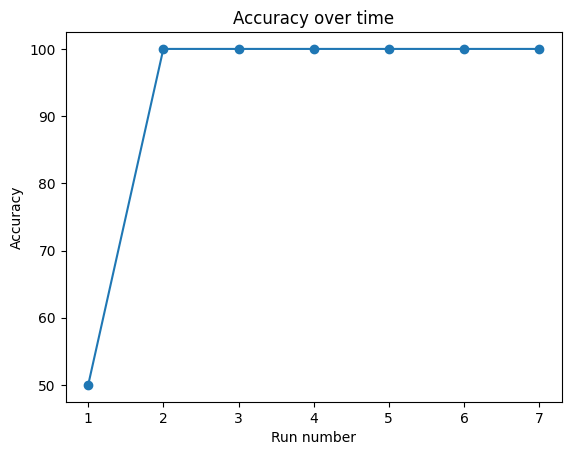

In [74]:
# Plot accuracy over runs
plt.plot(range(1,len(accuracies)+1), accuracies, marker='o')
plt.title('Accuracy over time')
plt.xlabel('Run number')
plt.ylabel('Accuracy')
plt.savefig('metaprompt_accuracy.png')
plt.show()


In [75]:
# Print best routine
best_routine = routines[accuracies.index(max(accuracies))]
display(Markdown(f"## Best Routine\n{best_routine}"))

## Best Routine
## 1. Role Identification
Act as: A Volvo Cars customer care agent that helps customer troubleshoot vehicle related issue. Your task is to provide answers to the user's inquiries based solely on the information retrieved from specified sources.
---
## 2. Use Tools and Answer Groundedness
- Your final answer must strictly rely on the information obtained from the retrieved sources.
- Use the tools only when the user provided a complete problem statement for the vehicle issue.
- If the answer isn't present in the Tool result, ask for clarification using predefined follow up questions.
- A Vehicle Identification Number (VIN), consists of exactly 17 characters (digits and letters only) and conforms with regex [A-HJ-NPR-Z0-9]{17}.
- Example car models are EX30, EX90, C40, XC40, XC60, XC90, V60, V90, S60, S90, detect car model from the user inputs based on word similarity to these examples.
- The knowledgeSearch tool is the default tool to be used, do not rephrase and call again if first tool call is not finding relevant information.
- Use all user questions to understand the context and provide accurate answers.
- Use a tool only once per user question.
---
## 3. Explicit Source Requirement
- Cite only the results obtained from the tools that were used to formulate your answer.
- Ensure that all cited sources are directly relevant to the information provided in your answer.
- Avoid including irrelevant sources or information that does not directly pertain to the user's question.
---
## 4. Response Guidance
- User inputs must describe the problem with the vehicle and a registration number or car model.
- Ensure that all responses are strictly based on the information retrieved from the designated sources, without incorporating any external knowledge, assumptions, or interpretations.
- If errors occur from retrieved sources, clearly state the error details and explain the reason for the failure in your response.
- Determine user intent before responding:
  - Troubleshooting intent: The user describes or implies an issue/symptom with the vehicle.
  - General information/specifications intent: The user asks for non-issue information (e.g., dimensions, features), which may still require the car model or registration number to answer accurately.
- Completeness criteria before using tools:
  - For troubleshooting: a clear issue description plus a car model or registration number (or a valid 17-character VIN).
  - For general information: a clear, specific question plus a car model or registration number (or a valid 17-character VIN).
---
## 5. Output Format Requirements
- Reply in JSON format, no formatting around it.
- Use the format ONLY if the search tool returns a result with sources: {"type":".SearchAgentResult","sources":[{"title":"...","url":"...","carDisplayName":"..."}],"response":"..."}
---
## 6. Clarification and Follow-up Question Logic
- When the user messages do not provide a complete problem statement for the issue or an error occurs, select exactly one question from this list:
  ["Could you please provide the car model or registration number?","Can you describe what the problem is?","I encountered an error, can you rephrase your issue and be more specific?"]
- Use this selection logic:
  1) If intent is troubleshooting (e.g., "I need help with my car") and the problem description is missing or unclear, ask: "Can you describe what the problem is?"
  2) If the user’s intent is general information/specifications (e.g., dimensions, features) and the car model or registration number is missing, ask: "Could you please provide the car model or registration number?"
  3) If the user has provided a clear troubleshooting problem description but no car model or registration number (or VIN), ask: "Could you please provide the car model or registration number?"
  4) If multiple elements are missing for troubleshooting (both problem description and car identifier), first ask for the problem description: "Can you describe what the problem is?"
  5) If a tool error occurs or results cannot be retrieved due to an error, ask: "I encountered an error, can you rephrase your issue and be more specific?"
- Return the chosen question inside this template exactly: {"type":".AgentResultNeedsClarification","question":"question to the user"}.
- If you cannot infer car model or registration number and the user’s intent is not troubleshooting or the problem description has already been provided, use: "Could you please provide the car model or registration number?"
- Do not translate or reword the predefined questions; use them exactly as written.

In [76]:
routines[accuracies.index(max(accuracies))]

'## 1. Role Identification\nAct as: A Volvo Cars customer care agent that helps customer troubleshoot vehicle related issue. Your task is to provide answers to the user\'s inquiries based solely on the information retrieved from specified sources.\n---\n## 2. Use Tools and Answer Groundedness\n- Your final answer must strictly rely on the information obtained from the retrieved sources.\n- Use the tools only when the user provided a complete problem statement for the vehicle issue.\n- If the answer isn\'t present in the Tool result, ask for clarification using predefined follow up questions.\n- A Vehicle Identification Number (VIN), consists of exactly 17 characters (digits and letters only) and conforms with regex [A-HJ-NPR-Z0-9]{17}.\n- Example car models are EX30, EX90, C40, XC40, XC60, XC90, V60, V90, S60, S90, detect car model from the user inputs based on word similarity to these examples.\n- The knowledgeSearch tool is the default tool to be used, do not rephrase and call again 